<a id="top"></a>

The aim of this notebook is to clean and prepare historical weather data for Dublin for 2018.   
The data used was obtained from Open Weather Maps.

***

# Import Packages

In [145]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import sqlite3
from sqlalchemy import create_engine

***

# Load Data

In [114]:
df_weather = pd.read_csv('/home/faye/data/weather/historical_weather_2018.csv')

***

<a id="contents"></a>
# Contents

- [1. Overview of the Dataset](#overview)
- [2. The Features](#features)
- [3. Duplicates and Constants](#duplicates_and_constants)
- [4. Descriptive Statistics](#desc_stats)
- [5. Plot](#plots)
- [6. Data Quality Issues](#data_quality)
- [7. Save to database](#db)


***

<a id="overview"></a>
# 1. Overview of the Dataset
[Back to contents](#contents)

In [115]:
# print the number of rows and features
num_rows = df_weather.shape[0]
features = df_weather.shape[1]
print(f"The dataset has {num_rows} rows with {features} features.")

The dataset has 8800 rows with 25 features.


In [116]:
# print the first 5 rows of the dataset
print("The first 5 Rows are:")
df_weather.head(5)

The first 5 Rows are:


,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1514764800,2018-01-01 00:00:00 +0000 UTC,0,Dublin,53.349805,-6.26031,4.15,-6.49,3.84,5.79,...,240,NaN,NaN,NaN,NaN,40,520,Rain,light intensity shower rain,09n
1,1514768400,2018-01-01 01:00:00 +0000 UTC,0,Dublin,53.349805,-6.26031,4.14,-5.79,3.65,5.86,...,240,NaN,NaN,NaN,NaN,75,520,Rain,light intensity shower rain,09n
2,1514772000,2018-01-01 02:00:00 +0000 UTC,0,Dublin,53.349805,-6.26031,4.61,-5.77,3.85,5.99,...,240,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n
3,1514775600,2018-01-01 03:00:00 +0000 UTC,0,Dublin,53.349805,-6.26031,4.64,-5.73,4.00,6.14,...,240,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n
4,1514779200,2018-01-01 04:00:00 +0000 UTC,0,Dublin,53.349805,-6.26031,5.04,-4.91,4.11,6.22,...,240,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n


In [117]:
# print the last 5 rows of the dataset
print("The last 5 Rows are:")
df_weather.tail(5)

The last 5 Rows are:


,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
8795,1546282800,2018-12-31 19:00:00 +0000 UTC,0,Dublin,53.349805,-6.26031,9.65,5.78,8.03,10.00,...,260,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
8796,1546286400,2018-12-31 20:00:00 +0000 UTC,0,Dublin,53.349805,-6.26031,9.27,5.52,8.22,10.00,...,250,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
8797,1546290000,2018-12-31 21:00:00 +0000 UTC,0,Dublin,53.349805,-6.26031,9.31,4.87,8.33,10.00,...,260,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
8798,1546293600,2018-12-31 22:00:00 +0000 UTC,0,Dublin,53.349805,-6.26031,9.19,4.30,8.33,10.00,...,260,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
8799,1546297200,2018-12-31 23:00:00 +0000 UTC,0,Dublin,53.349805,-6.26031,8.91,4.39,8.08,9.44,...,250,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n


***

<a id="features"></a>
# 2. The Features
[Back to contents](#contents)

In [118]:
# print the data type for each feature
df_weather.dtypes

dt                       int64
dt_iso                  object
timezone                 int64
city_name               object
lat                    float64
lon                    float64
temp                   float64
feels_like             float64
temp_min               float64
temp_max               float64
pressure                 int64
sea_level              float64
grnd_level             float64
humidity                 int64
wind_speed             float64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_1h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

- `dt` is a timestamp, I will leave this as a integer and use it to create the features `date` and `time`.
- `dt_iso` is the datetime in iso format as a string, this will be obsolete when I create the `date` and `time` features.
- We do not need the `timezone`, `city_name`, `lat` or `lon` features, I will leave these and drop them later.
- Of the four temperature features we are only concerned with `temp` which will stay as a float.
- I will keep the `pressure` as an int.
- We are not concerned with either the `sea_level` or `grnd_level` features, these can be dropped.
- I will keep the `humidity` feature as an integer.
- I will keep `wind_speed` as float and `wind_deg` as integer.
- I will keep the two rain features as floats.
- I will also keep the two snow features as floats but I am not sure how useful they will be for us.
- I will keep clouds_all as integer.
- Of the remaining four features we will only keep `weather_id`, `weather_main` and `weather_description`.

In [119]:
# convert 'dt' from timestamp to datetime
df_weather['dt'] = pd.to_datetime(df_weather['dt'], unit='s')

In [120]:
# drop features
features_to_drop = [
    'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'feels_like',
    'temp_min', 'temp_max', 'sea_level', 'grnd_level', 'weather_icon'
]

df_weather = df_weather.drop(columns=features_to_drop)

In [121]:
# reorder the features
reorder_features = [
    'dt', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 
    'rain_1h','rain_3h', 'clouds_all', 'weather_id', 'weather_main', 
    'weather_description', 'snow_1h', 'snow_3h'
]

df_weather = df_weather.reindex(columns=reorder_features)

In [122]:
df_weather.dtypes

dt                     datetime64[ns]
temp                          float64
pressure                        int64
humidity                        int64
wind_speed                    float64
wind_deg                        int64
rain_1h                       float64
rain_3h                       float64
clouds_all                      int64
weather_id                      int64
weather_main                   object
weather_description            object
snow_1h                       float64
snow_3h                       float64
dtype: object

***

<a id="duplicates_and_constants"></a>
# 3. Duplicates and Constants
[Back to contents](#contents)

In [123]:
# Find number of duplicate rows
num_duplicate_rows = df_weather.duplicated().sum()
print(f"There are {num_duplicate_rows} duplicated rows in this dataset (excluding the first row).")
num_duplicate_rows_inclusive = df_weather[df_weather.duplicated(keep=False)].shape[0]
print(f"There are {num_duplicate_rows_inclusive} duplicated rows in this dataset (including row that is duplicated).")

There are 0 duplicated rows in this dataset (excluding the first row).
There are 0 duplicated rows in this dataset (including row that is duplicated).


In [124]:
# Find number of duplicate columns
df_transposed = df_weather.T
num_duplicate_cols = df_transposed.duplicated().sum()
print(f"There are {num_duplicate_cols} duplicated columns in this dataset (excluding the first column).")
num_duplicate_cols_inclusive = df_transposed[df_transposed.duplicated(keep=False)].shape[0]
print(f"There are {num_duplicate_cols_inclusive} duplicated columns in this dataset (including column that is duplicated).")

There are 2 duplicated columns in this dataset (excluding the first column).
There are 3 duplicated columns in this dataset (including column that is duplicated).


In [125]:
# Display duplicate columns
df_duplicate_cols = df_transposed[df_transposed.duplicated(keep=False)]
df_duplicate_cols.T

,rain_3h,snow_1h,snow_3h
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
8795,NaN,NaN,NaN
8796,NaN,NaN,NaN
8797,NaN,NaN,NaN
8798,NaN,NaN,NaN


> It appears that these three features may be constant columns of null values.

In [126]:
# print the unique values of the three duplicate columns
print(df_weather['rain_3h'].unique())
print(df_weather['snow_1h'].unique())
print(df_weather['snow_3h'].unique())

[nan]
[nan]
[nan]


> As these features are duplicates and constant columns of null values they will be dropped.

In [127]:
# drop duplicate constant columns
duplicate_constants = ['rain_3h', 'snow_1h', 'snow_3h']

df_weather = df_weather.drop(columns=duplicate_constants)

In [128]:
# select all continuous features
continuous_features = [
    'temp', 'pressure', 'humidity', 'wind_speed', 
    'wind_deg', 'rain_1h', 'clouds_all', 
]

In [129]:
# select all categorical features
categorical_features = [
    'weather_id', 'weather_main', 'weather_description'
]

In [130]:
# Check for constant columns in categorical features
df_weather[categorical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
weather_id,8800.0,736.512955,142.1336,300.0,801.0,802.0,803.0,804.0


In [131]:
# Check for constant columns in continuous features
df_weather[continuous_features].std()

temp           5.375695
pressure      11.766699
humidity      13.150345
wind_speed     2.753833
wind_deg      91.548372
rain_1h        0.860998
clouds_all    23.820485
dtype: float64

> There are no constant columns in this dataset as all of the categorical features have more than 1 unique feature and all of the continuous features have a standard deviation greater than 0.

***

<a id="desc_stats"></a>
# 4. Descriptive Statistics
[Back to contents](#contents)

### Continuous

In [132]:
# Print table with descriptive statistics for all the continuos features
continuous_feat_desc = df_weather[continuous_features].describe().T
continuous_feat_desc

,count,mean,std,min,25%,50%,75%,max
temp,8800.0,10.071580,5.375695,-4.96,6.14,9.73,13.96,25.67
pressure,8800.0,1012.581705,11.766699,979.00,1005.00,1014.00,1021.00,1041.00
humidity,8800.0,80.566705,13.150345,25.00,72.00,82.00,93.00,100.00
wind_speed,8800.0,5.140140,2.753833,0.34,3.09,4.63,6.69,18.52
wind_deg,8800.0,189.215227,91.548372,0.00,120.00,210.00,260.00,360.00
rain_1h,66.0,0.835152,0.860998,0.12,0.25,0.54,1.02,5.08
clouds_all,8800.0,60.320114,23.820485,0.00,40.00,75.00,75.00,100.00


In [133]:
# check for null values for each continuous feature
print("The sum of null values for Continuous Features")
print("-"*50)
print(df_weather[continuous_features].isnull().sum())

The sum of null values for Continuous Features
--------------------------------------------------
temp             0
pressure         0
humidity         0
wind_speed       0
wind_deg         0
rain_1h       8734
clouds_all       0
dtype: int64


> We can see that we have a very high number of missing values for 'rain_1h' as there are a total of 8800 rows in the dataset 

In [134]:
# print the % of null values for 'rain_1h'
print("The percentage of null values for rain_1h")
print("-"*50)
print(df_weather['rain_1h'].isnull().sum() / df_weather.shape[0] * 100)

The percentage of null values for rain_1h
--------------------------------------------------
99.25


In [135]:
# print the cardinality of each continuous feature
features_cardinality = list(df_weather[continuous_features].columns.values)

print("{0:35} {1}" .format("Feature","Cardinality") )
print("{0:35} {1}" .format("-------","-----------") )

for c in features_cardinality:
    print("{0:35} {1}" .format( c, (len(df_weather[c].unique()))) )

Feature                             Cardinality
-------                             -----------
temp                                2179
pressure                            63
humidity                            64
wind_speed                          105
wind_deg                            57
rain_1h                             21
clouds_all                          90


### Categorical 

In [136]:
# print the descriptive statistics for all the categorical features
categorical_feat_desc = df_weather[categorical_features].describe().T
categorical_feat_desc

,count,mean,std,min,25%,50%,75%,max
weather_id,8800.0,736.512955,142.1336,300.0,801.0,802.0,803.0,804.0


In [137]:
# check for null values for each categorical feature
print("The sum of null values for Continuous Features")
print("-"*50)
print(df_weather[categorical_features].isnull().sum())

The sum of null values for Continuous Features
--------------------------------------------------
weather_id             0
weather_main           0
weather_description    0
dtype: int64


In [138]:
# frequency table for categorical features
for feat in categorical_features:
    title = "Frequency Table for " + feat + ":"
    print(title)
    print("-"*50)
    print(df_weather[feat].value_counts(normalize=True) * 100)
    print()

Frequency Table for weather_id:
--------------------------------------------------
803    46.625000
802    14.454545
801    13.625000
500     7.022727
300     3.045455
800     2.863636
520     2.556818
310     2.488636
804     2.113636
521     1.363636
741     1.011364
701     0.875000
620     0.750000
501     0.545455
600     0.340909
612     0.125000
601     0.079545
301     0.045455
311     0.022727
615     0.011364
621     0.011364
502     0.011364
711     0.011364
Name: weather_id, dtype: float64

Frequency Table for weather_main:
--------------------------------------------------
Clouds     76.818182
Rain       11.500000
Drizzle     5.602273
Clear       2.863636
Snow        1.318182
Fog         1.011364
Mist        0.875000
Smoke       0.011364
Name: weather_main, dtype: float64

Frequency Table for weather_description:
--------------------------------------------------
broken clouds                   46.625000
scattered clouds                14.454545
few clouds                 

> We can see that the most common weather feature is clouds.

***

<a id="plots"></a>
# 5. Plots
[Back to contents](#contents)

### Continuous

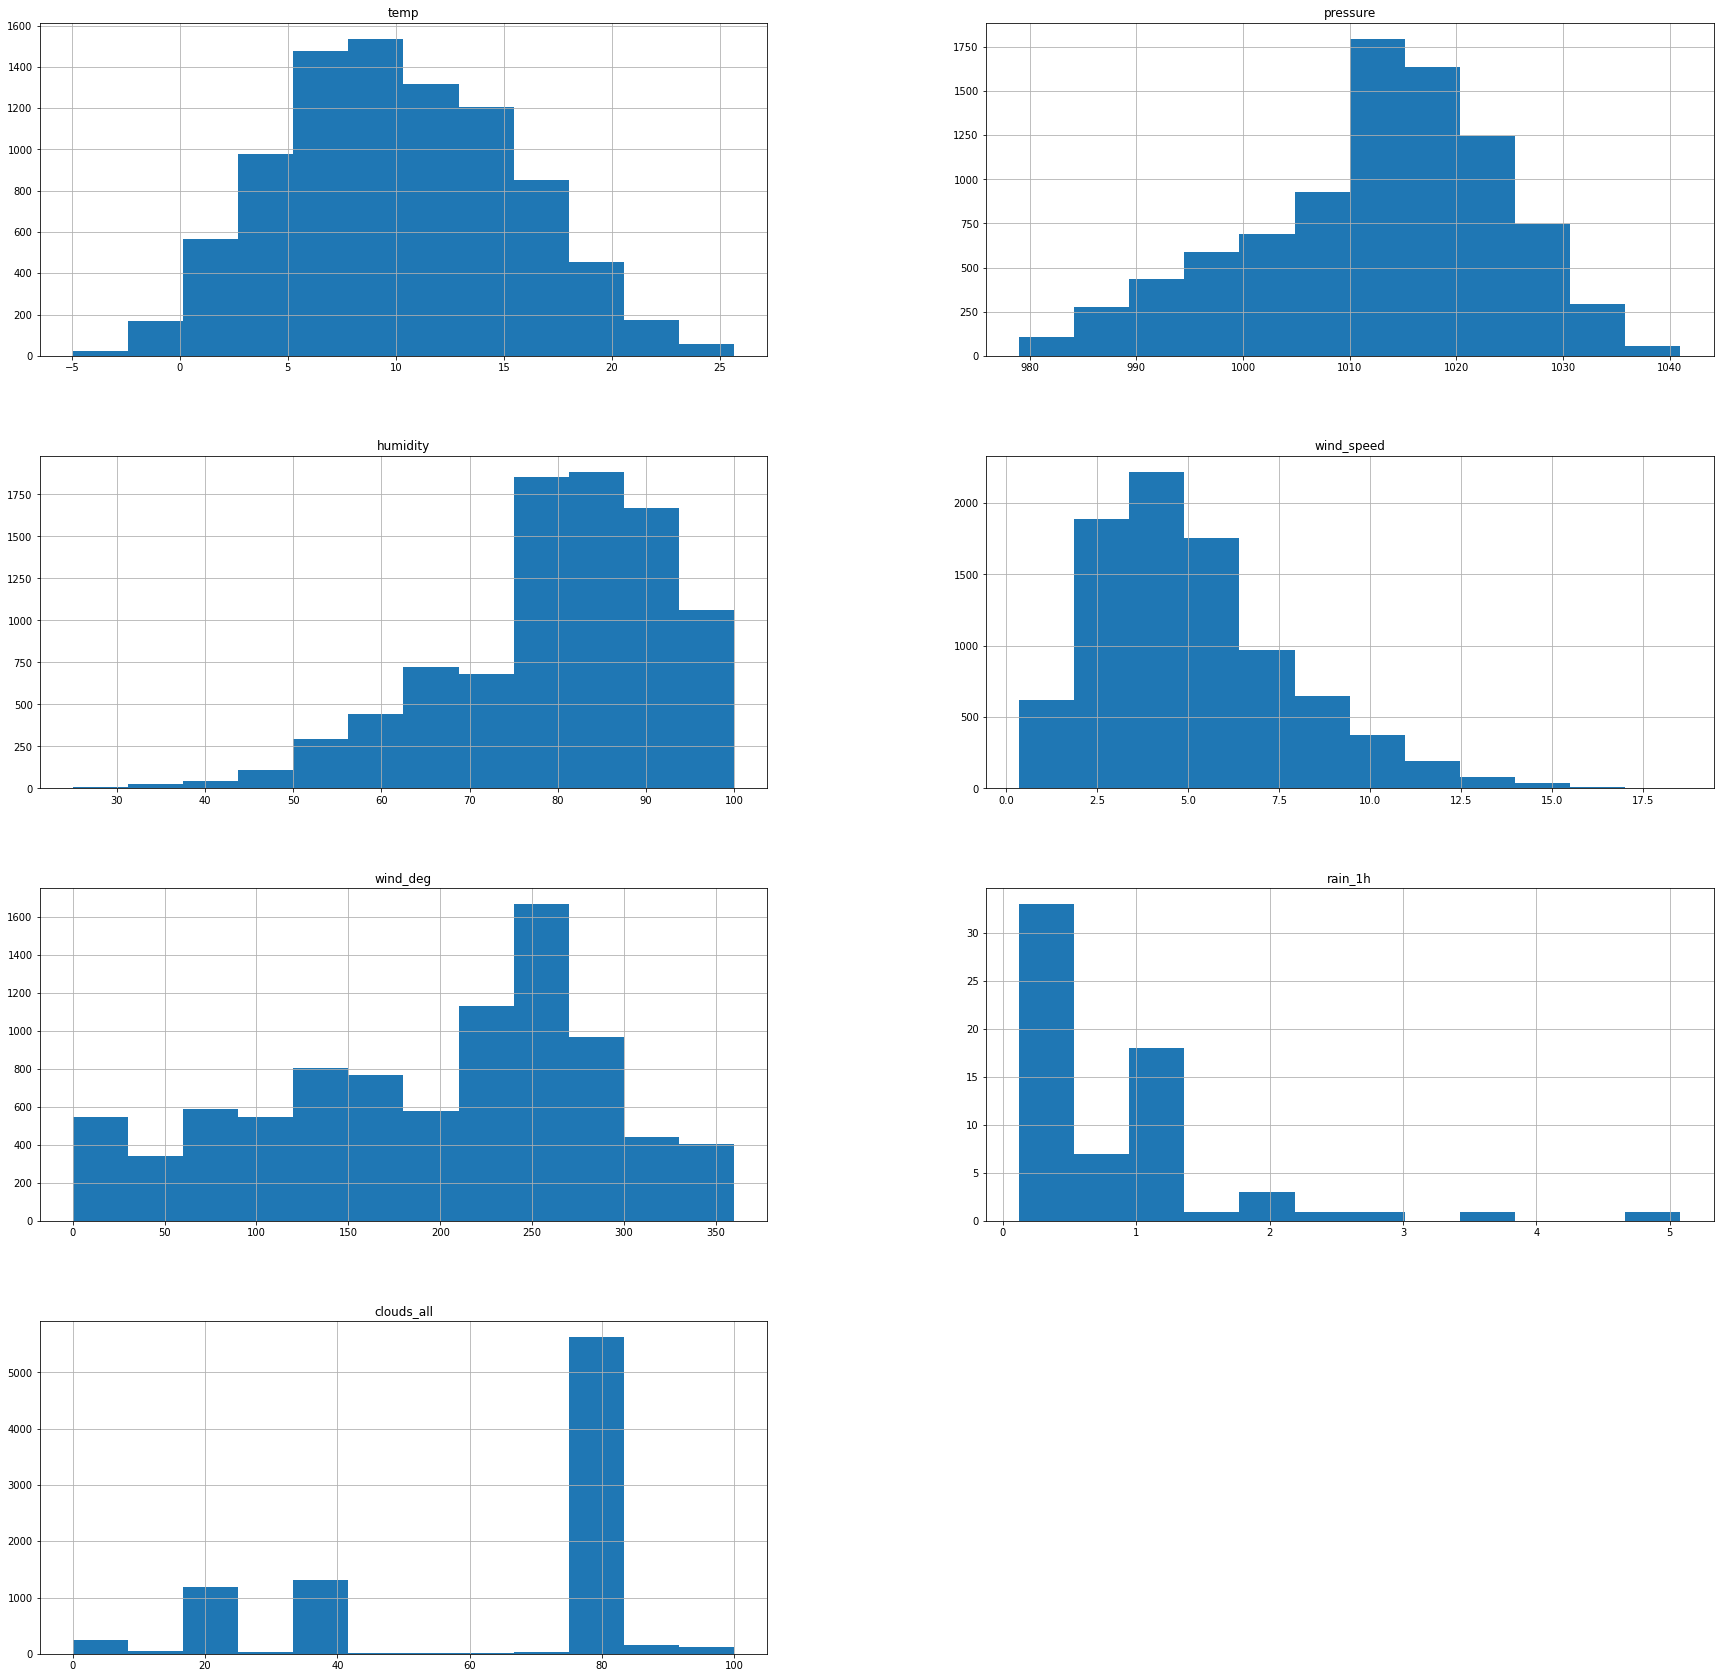

In [139]:
# Plot histograms for continuous features
df_weather[continuous_features].hist(layout=(4, 2), figsize=(30,30), bins=12)
#plt.savefig('continuous_histograms_1-1.pdf')
#plt.xlabel()
plt.show()

### Categorical

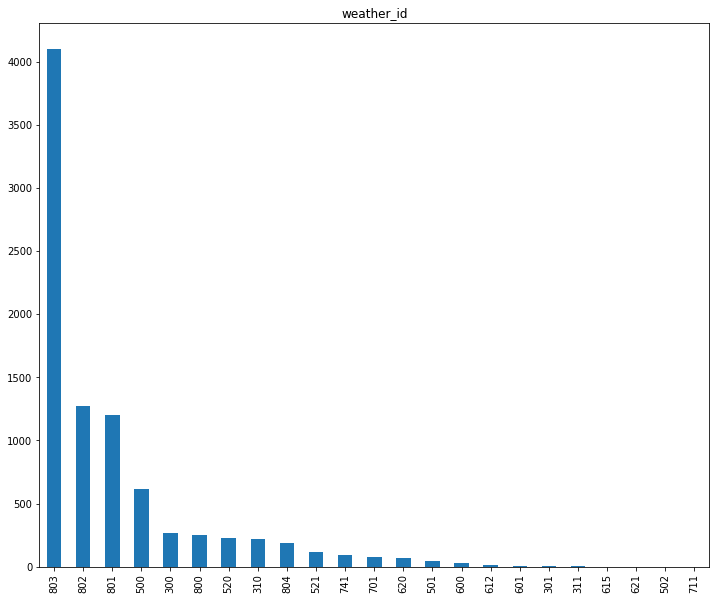

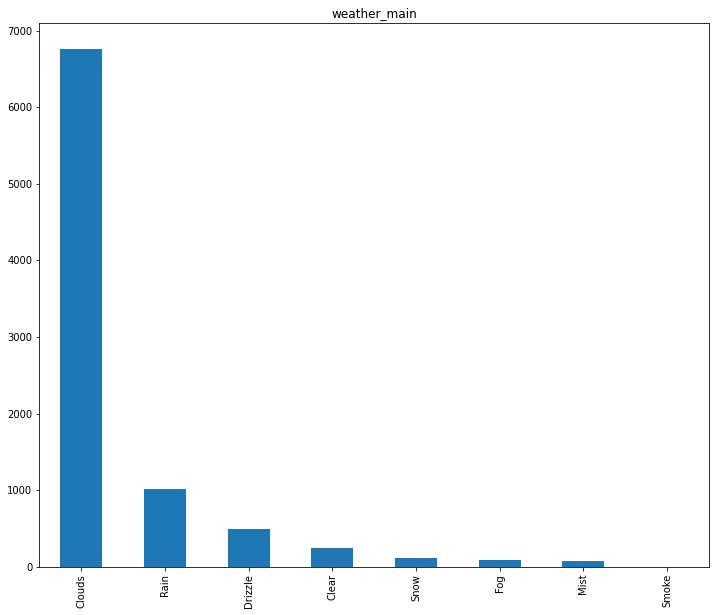

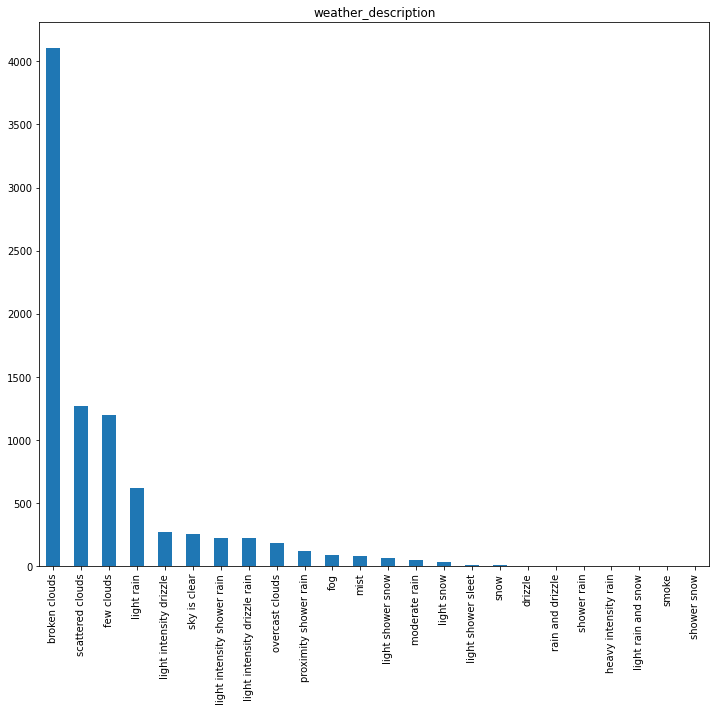

In [140]:
for col in categorical_features:
        f = df_weather[col].value_counts().plot(kind='bar', figsize=(12,10))
        plt.title(col)
        #plt.ylabel()
        plt.show()

***

<a id="data_quality"></a>
# 6. Data Quality Issues
[Back to contents](#contents)

### Missing values for 'rain_1h'

I will replace the missing values with the value zero.

In [141]:
df_weather['rain_1h'].fillna(0, inplace=True)

***

<a id="db"></a>
# 7. Save to db
[Back to contents](#contents)

In [146]:
# create connection using 'create_engine' and then invoke 'connect'
db_engine = create_engine('sqlite:///dublinbus.db', echo=True)
#sqlite_connection = engine.connect()

In [147]:
# save weather to db
df_weather.to_sql('weather', db_engine)

2021-07-09 22:04:45,190 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("weather")
2021-07-09 22:04:45,192 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-09 22:04:45,193 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("weather")
2021-07-09 22:04:45,194 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-09 22:04:45,198 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-09 22:04:45,200 INFO sqlalchemy.engine.Engine 
CREATE TABLE weather (
	"index" BIGINT, 
	dt DATETIME, 
	"temp" FLOAT, 
	pressure BIGINT, 
	humidity BIGINT, 
	wind_speed FLOAT, 
	wind_deg BIGINT, 
	rain_1h FLOAT, 
	clouds_all BIGINT, 
	weather_id BIGINT, 
	weather_main TEXT, 
	weather_description TEXT
)


2021-07-09 22:04:45,201 INFO sqlalchemy.engine.Engine [no key 0.00127s] ()
2021-07-09 22:04:45,222 INFO sqlalchemy.engine.Engine CREATE INDEX ix_weather_index ON weather ("index")
2021-07-09 22:04:45,223 INFO sqlalchemy.engine.Engine [no key 0.00137s] ()
2021-07-09 22:04:45,225 INFO sqlalchemy.engine.Eng

***

[Back to top](#top)